### Import Library dan Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.nn.utils import clip_grad_norm_
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    get_scheduler
)
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

/home/sorr/anaconda3/envs/skripsi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./data/data_cleaned.csv')
df.head()

,Tweet,Label
0,aib bodoh benar sebelum kata aib itu muncul te...,Marah
1,lo takut enggak sih anjir selasa depan anjir t...,Takut
2,feb hari ini flight balik jakarta sedih degdeg...,Sedih
3,gajian saja belum sudah ada yang mengomong nan...,Sedih
4,selamat pagi juga pak suryo salam sehat penuh ...,Gembira


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())

2.8.0+cu129
True
0
NVIDIA GeForce RTX 5070


### Persiapan Dataset

In [4]:
label_encoder = LabelEncoder()
df["LabelEncoded"] = label_encoder.fit_transform(df["Label"])
num_labels = len(label_encoder.classes_)

id2label = {i: lab for i, lab in enumerate(label_encoder.classes_)}
label2id = {lab: i for i, lab in id2label.items()}

In [5]:
# Splitting Dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Tweet"], df["LabelEncoded"], test_size=0.3, stratify=df["LabelEncoded"], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

In [6]:
# Konversi ke Dataset Hugging Face
dataset = DatasetDict({
    "train": Dataset.from_dict(
        {"text": list(train_texts), 
         "labels": list(train_labels)}),
    "validation": Dataset.from_dict(
        {"text": list(val_texts), 
         "labels": list(val_labels)}),
    "test": Dataset.from_dict(
        {"text": list(test_texts), 
         "labels": list(test_labels)}),
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 3466
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 743
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 743
    })
})

### Tokenisasi

In [7]:
# Mengambil Tokenizer dari model IndoBERT
MODEL_NAME = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )


tokenized_dataset = dataset.map(
    tokenize_function, 
    batched=True, 
    remove_columns=["text"])

tokenized_dataset.set_format(
    "torch", 
    columns=["input_ids", 
            "attention_mask", 
            "labels"])

Map: 100%|██████████| 743/743 [00:00<00:00, 32889.38 examples/s]


In [8]:
# Data Batching dan Batch Preparation
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer, return_tensors="pt")

train_loader = DataLoader(
    tokenized_dataset["train"], batch_size=16, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(
    tokenized_dataset["validation"], batch_size=16, collate_fn=data_collator)
test_loader = DataLoader(
    tokenized_dataset["test"], batch_size=16, collate_fn=data_collator)

### Fine-Tuning

In [9]:
# Menyiapkan Model untuk Fine-Tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id)
).to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 5
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear", 
    optimizer=optimizer, 
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
# Training Loop

history = {
    "train_loss": [], "val_loss": [],
    "train_acc":  [], "val_acc":  [],
    "train_f1":   [], "val_f1":   []
}

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0.0
    train_preds, train_labels_all = [], []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for batch in pbar:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()                         
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch["labels"])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        train_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        train_preds.extend(preds)
        train_labels_all.extend(labels)

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = train_loss / len(train_loader)
    train_acc = accuracy_score(train_labels_all, train_preds)
    train_f1 = f1_score(train_labels_all, train_preds, average="macro")

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    val_preds, val_labels_all = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = loss_fn(outputs.logits, batch["labels"])
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()
            val_preds.extend(preds)
            val_labels_all.extend(labels)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels_all, val_preds)
    val_f1 = f1_score(val_labels_all, val_preds, average="macro")

    # simpan history
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)

    # tampilkan ringkasan per-epoch (mirip TF)
    print(
        f"loss: {avg_train_loss:.4f} - acc: {train_acc:.4f} - f1: {train_f1:.4f} - "
        f"val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f} - val_f1: {val_f1:.4f}"
    )

Epoch 1/5 - Training: 100%|██████████| 217/217 [00:26<00:00,  8.11it/s, loss=0.6921]


loss: 1.2894 - acc: 0.4625 - f1: 0.4467 - val_loss: 0.6807 - val_acc: 0.8022 - val_f1: 0.8043


Epoch 2/5 - Training: 100%|██████████| 217/217 [00:26<00:00,  8.33it/s, loss=0.3687]


loss: 0.5777 - acc: 0.8214 - f1: 0.8202 - val_loss: 0.5366 - val_acc: 0.8493 - val_f1: 0.8497


Epoch 3/5 - Training: 100%|██████████| 217/217 [00:26<00:00,  8.29it/s, loss=0.2492]


loss: 0.4169 - acc: 0.8725 - f1: 0.8706 - val_loss: 0.4964 - val_acc: 0.8520 - val_f1: 0.8519


Epoch 4/5 - Training: 100%|██████████| 217/217 [00:25<00:00,  8.41it/s, loss=0.0470]


loss: 0.3152 - acc: 0.9033 - f1: 0.9022 - val_loss: 0.5204 - val_acc: 0.8560 - val_f1: 0.8549


Epoch 5/5 - Training: 100%|██████████| 217/217 [00:26<00:00,  8.23it/s, loss=0.3050]


loss: 0.2500 - acc: 0.9256 - f1: 0.9246 - val_loss: 0.5155 - val_acc: 0.8600 - val_f1: 0.8586


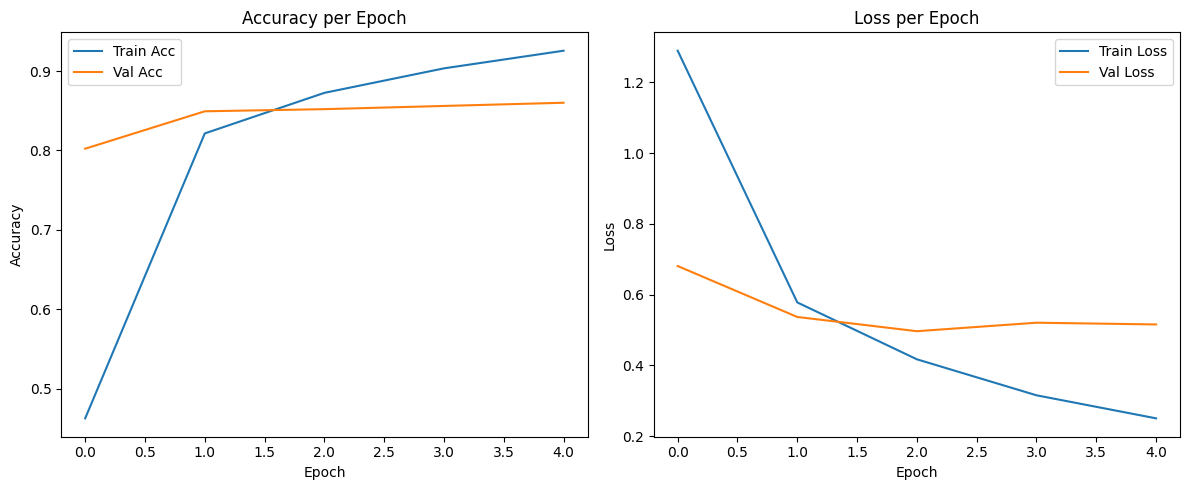

In [12]:
# Plot Training History

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### Evaluasi

In [13]:
# Evaluasi
model.eval()
test_preds, test_labels_all = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        test_preds.extend(preds)
        test_labels_all.extend(labels)
        
# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels_all,
      test_preds, target_names=label2id.keys()))


Classification Report:
              precision    recall  f1-score   support

       Cinta       0.77      0.85      0.81       113
     Gembira       0.90      0.83      0.86       188
       Marah       0.85      0.82      0.83       157
       Sedih       0.79      0.85      0.82       149
       Takut       0.87      0.86      0.87       136

    accuracy                           0.84       743
   macro avg       0.84      0.84      0.84       743
weighted avg       0.84      0.84      0.84       743



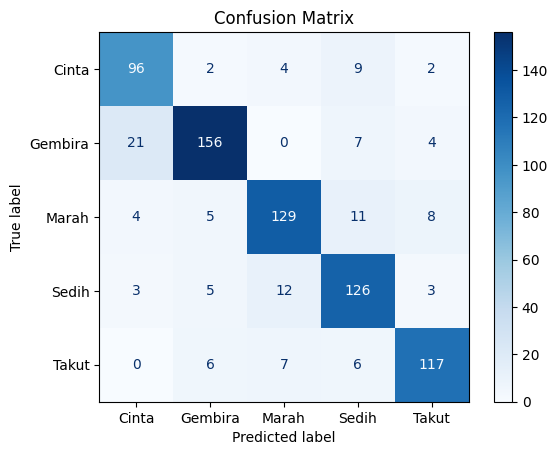

In [14]:
# Confusion Matrix
cm = confusion_matrix(test_labels_all, test_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=label2id.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()